In [82]:
# Starts the autoreload extension, which allows editing the .py files with the notebook running and automatically imports the latest changes

%load_ext autoreload
%autoreload 2

# Imports all the libraries used

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix
from umap import UMAP
from tqdm import tqdm

from functools import partial

import jax
from jax import numpy as jnp
import haiku as hk
import optax

import resnet
import data
import train
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
assert jax.local_device_count() >= 8, "TPUs not detected"

In [84]:
NUM_CLASSES = 4
SEED = 12
BATCH_SIZE = 128

jax.config.update("jax_debug_nans", False)
classes = ['Normal', 'Pneumonia-Bacterial', 'COVID-19', 'Pneumonia-Viral']

rng = jax.random.PRNGKey(SEED)

In [140]:
(x_train, y_train), (x_test, y_test) = data.load_data('.', rng, test_size = 0.1)

x_all = np.concatenate([x_test, x_train])
y_all = np.concatenate([y_test, y_train])

tcmalloc: large alloc 7241465856 bytes == 0x3f6c3c000 @  0x7f7ecf81a680 0x7f7ecf83b824 0x7f7ec4dac4ce 0x7f7ec4e0200e 0x7f7ec4e02c4f 0x7f7ec4ea4924 0x5f2cc9 0x5f30ff 0x5705f6 0x568d9a 0x5f5b33 0x56bc9b 0x568d9a 0x5f5b33 0x56fb87 0x568d9a 0x5f5b33 0x56bc9b 0x568d9a 0x68cdc7 0x5ff5d4 0x5c3cb0 0x56aadf 0x501148 0x56c422 0x501148 0x56c422 0x501148 0x504d56 0x56acb6 0x5f5956
tcmalloc: large alloc 7241465856 bytes == 0x8aefc000 @  0x7f7ecf81a680 0x7f7ecf83b824 0x7f7ecf83bb8a 0x7f7bb9194c37 0x7f7bb91475eb 0x7f7bb91587a6 0x7f7bb91596dd 0x7f7bb4fc2b09 0x7f7bb4fc61a0 0x7f7bb8e74302 0x7f7bb656f220 0x7f7bb656f910 0x7f7bb654ae95 0x7f7bb6551686 0x7f7bb6553434 0x7f7bb41533bf 0x7f7bb3ecc9a8 0x7f7bb3ebc540 0x5f2cc9 0x5f3010 0x50bf55 0x56fb87 0x568d9a 0x5f5b33 0x5f5308 0x6655bd 0x5f28fe 0x56c332 0x568d9a 0x5f5b33 0x5f5369
tcmalloc: large alloc 7241465856 bytes == 0x2449e0000 @  0x7f7ecf81a680 0x7f7ecf83b824 0x7f7ecf83bb8a 0x7f7bb9194c37 0x7f7bb91475eb 0x7f7bb91587a6 0x7f7bb91596dd 0x7f7bb4fc2b09 0x7f7bb4

In [86]:
def forward(batch, is_training, return_representation = False, return_gradcam = False, gradcam_counterfactual = False):
    net = resnet.ResNet18(num_classes = NUM_CLASSES, resnet_v2 = True)
    if return_representation:
        return net.embedding(batch, is_training, embedding_depth=0)
    elif return_gradcam:
        return net.gradcam(batch, is_training, gradcam_depth=0, counterfactual=gradcam_counterfactual)
    else:
        return net(batch, is_training)

net = hk.transform_with_state(forward)
schedule = optax.cosine_decay_schedule(1e-1, 30 * (len(x_train) // BATCH_SIZE))
optim = optax.adamw(schedule, weight_decay = 1e-3)

In [87]:
# Gets functions for the model
init_fn, loss_fn, grad_fn, update, predict, evaluate, train_epoch = train.get_network_fns(net, optim, BATCH_SIZE)

# Initializes parameters and state
params, state, optim_state = init_fn(rng)

In [88]:
# Train the model for 30 epochs
for i in range(30):
    params, state, optim_state = train_epoch(params, state, optim_state, x_train, y_train, x_test, y_test)


def load_model(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

#loaded_model = load_model("checkpoints/checkpoint.npy")
#params = loaded_model[0]
#state = loaded_model[1]
#optim_state = loaded_model[2]

100%|█████████████████████████████████| 64/64 [00:05<00:00, 11.02it/s, loss=0.14, acc=0.95, val_loss=0.35, val_acc=0.86]


In [107]:
import pickle

def save_model(filename):
    with open(filename, "wb") as f:
        pickle.dump((params, state, optim_state), f)

save_model("checkpoint.npy")

In [108]:
x_gradcam_data = x_train
y_gradcam_data = y_train

In [109]:
gradcam_batch_size = 8
datagen, num_batches = train.get_datagen(True, gradcam_batch_size, x_gradcam_data, y_gradcam_data, include_last = False)

# List with all the predictions
cams = []
counter_cams = []
# Applies the network to each batch
for x_batch, y_batch in tqdm(datagen()):
    apply = jax.pmap(net.apply, static_broadcasted_argnums = (2,4,5,6,7))
    cam = apply(params, state, None, x_batch, False, False, True, False)[0]
    counter_cam = apply(params, state, None, x_batch, False, False, True, True)[0]
    cams.append(cam)
    counter_cams.append(counter_cam)

cams = jnp.concatenate(cams)
counter_cams = jnp.concatenate(counter_cams)
cams.shape

1036it [00:22, 46.15it/s]


(8288, 4, 8, 8)

In [110]:
y_pred = predict(params, state, x_gradcam_data, training=False)
y_pred.shape

100%|███████████████████████████████████████████████████████████████████████████████████| 65/65 [00:13<00:00,  4.80it/s]


(8288, 4)

[Text(0.5, 1.0, 'Original Results')]

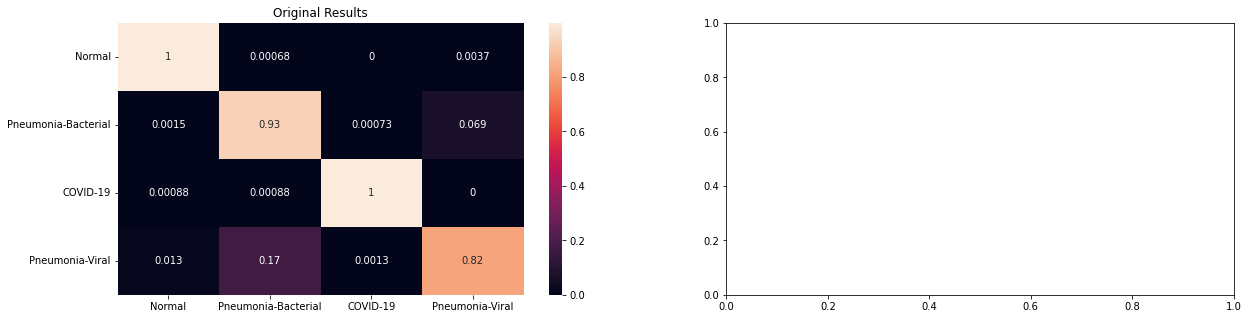

In [116]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5))
sn.heatmap(confusion_matrix(y_gradcam_data.argmax(1), y_pred.argmax(1), normalize = 'true'), ax = axs[0], annot = True, xticklabels = classes, yticklabels = classes).set(title = 'Original Results')

Perc correct 0.9956


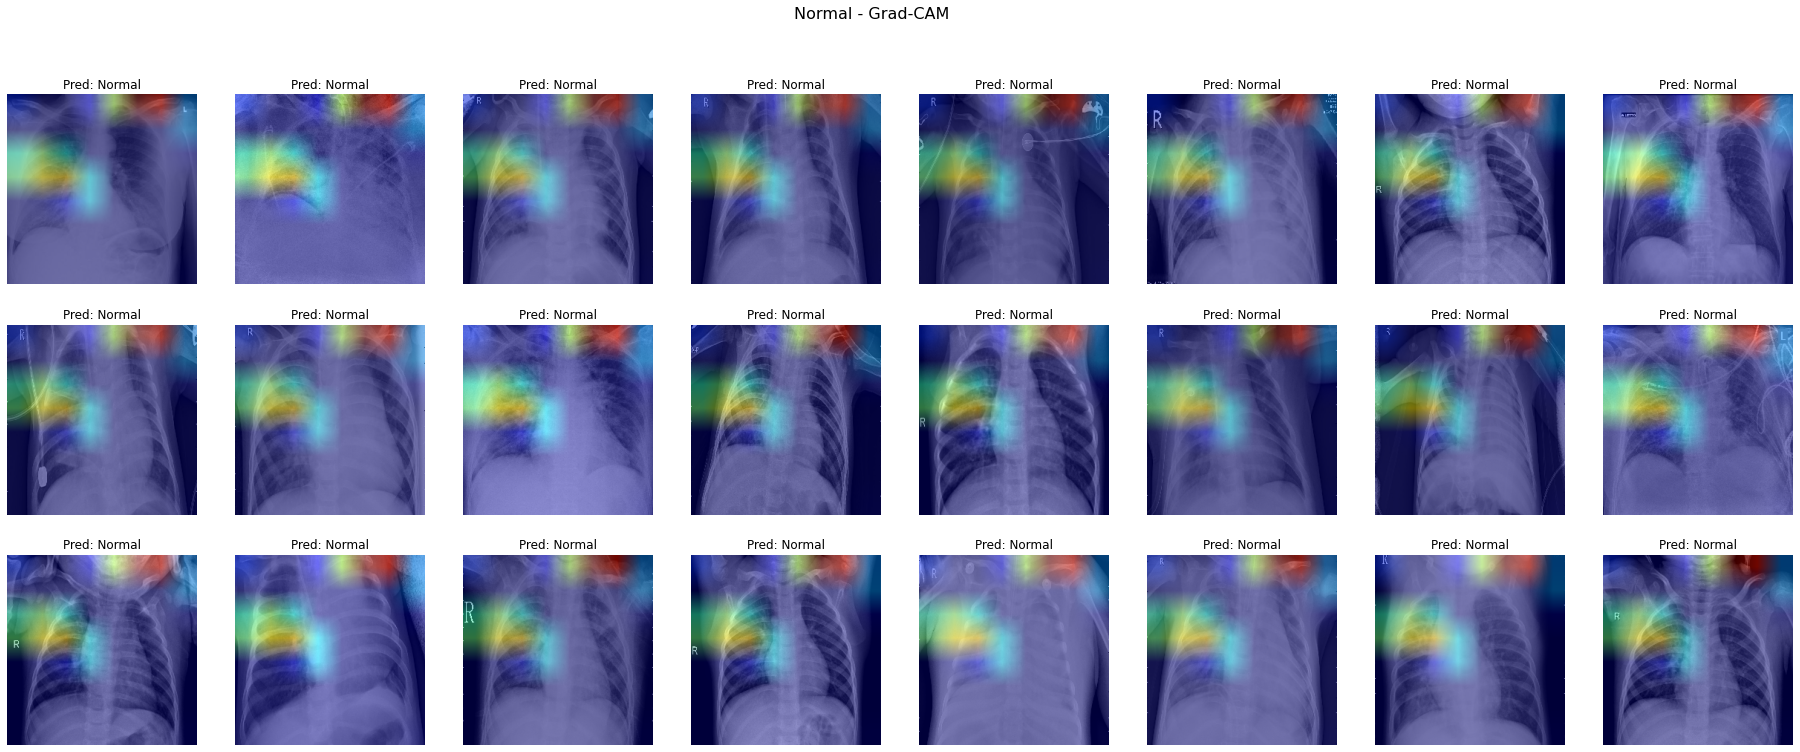

In [130]:
from IPython.display import Image, display
import matplotlib.cm as cm
import cv2
import utils

# TODO: something is wrong with the preview - compute error rates, maybe the wheres are messed up

def display_gradcam(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap /= heatmap.max()
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = cv2.resize(jet_heatmap, dsize=(img.shape[0], img.shape[1]), interpolation=cv2.INTER_LINEAR)
    jet_heatmap /= jet_heatmap.max()
    jet_heatmap = np.clip(jet_heatmap, 0, 1)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img /= superimposed_img.max()
    # Display Grad CAM
    plt.imshow(superimposed_img)

CLASS_TO_DISPLAY = utils.CLASS_NORMAL
PREVIEW_CLASS = utils.CLASS_NORMAL
COUNTERFACTUAL = False

ROWS = 3
COLUMNS = 8
DISPLAY_RNG = jax.random.PRNGKey(42)

real = jnp.argmax(y_gradcam_data, axis=1)
predicted = jnp.argmax(y_pred, axis=1)
assert predicted.shape[0] == real.shape[0] and real.shape[0] == y_gradcam_data.shape[0]

indices_of_class = jnp.where(real == CLASS_TO_DISPLAY)[0]

print("Perc correct {:.4f}".format(jnp.mean((predicted[indices_of_class] == CLASS_TO_DISPLAY).astype(jnp.float32))))

indices_of_class = jax.random.choice(DISPLAY_RNG, indices_of_class, shape=[ROWS*COLUMNS])

# create figure
fig = plt.figure(figsize=(32, 12))
fig.suptitle(utils.CLASS_NAMES[CLASS_TO_DISPLAY] + (" - Grad-CAM" if not COUNTERFACTUAL else " - Counterfactual Grad-CAM"), fontsize=16)

for i in range(ROWS*COLUMNS):
    fig.add_subplot(ROWS, COLUMNS, i+1)

    img_index = indices_of_class[i]
    class_index = real[img_index]
    pred = predicted[img_index]
    img = x_all[img_index,]

    if not COUNTERFACTUAL:
        heatmap = cam[img_index, PREVIEW_CLASS]
    else:
        heatmap = counter_cam[img_index, PREVIEW_CLASS]

    display_gradcam(img, heatmap, alpha=0.8)

    title = "Pred: " + utils.CLASS_NAMES[pred]

    plt.title(title)
    plt.axis('off')

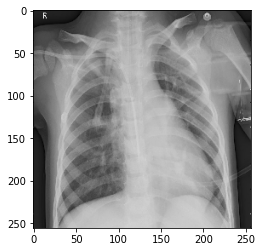

In [139]:
img = x_train[0,:,:,:].mean(axis=-1)
plt.imshow(np.stack((img,)*3, axis=-1))